In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')


# 문제 정의 

BNP는 보험회사로서, 고객의 claim에 더 빠르게 대응해야함. 
Claim에 대한 제기 여부를 판단하는 알고리즘이 필요. => 모델 개발
*평가 메트릭은 logloss 함수 사용할 것 

1. 더 빠른 결제 속도를 위한 승인 절차
2. 승인 전 추가적인 정보 필요

- 그렇다면, 보험사에서 고객의 claim에 제기 여부를 판단하는데에는 어떤 요소가 필요할까???
- 신용등급, 재산등급? vip들의 요청에는 더 빠르게 대응해야할 가능성.

# Data Loading

In [14]:
train = pd.read_csv('./data/bnp-claims-management/train.csv')
# train['target'].unique()
train.head()


,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


# EDA & Data Preprocessing

In [15]:
# 데이터 shape 확인
# 133 columns, 114321 rows
train.shape

(114321, 133)

In [16]:
# 데이터 타입 확인
train.info(max_cols=None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114321 entries, 0 to 114320
Columns: 133 entries, ID to v131
dtypes: float64(108), int64(6), object(19)
memory usage: 116.0+ MB


In [42]:
train['v131']

0         2.857144
1              NaN
2         1.176472
3         1.034483
4              NaN
            ...   
114316         NaN
114317         NaN
114318         NaN
114319         NaN
114320    1.386138
Name: v131, Length: 114321, dtype: float64

In [17]:
# target column check
# 0과 1로 이루어져있다. => T or F, 즉 clf 로 접근해야한다.
print(train['target'].unique())
target = train['target'].values
print(target)

[1 0]
[1 1 1 ... 1 1 1]


In [18]:
# 칼럼별 null 값의 비율 계산
# 결측치 비율이 40%가 넘어가는 칼럼이 꽤 있는 것으로 보인다. 더 자세히 봐야할 것 같다
null_percent = train.isnull().sum() * 100 / len(train)
null_percent.sort_values(ascending=False)

v30       52.580016
v113      48.376064
v102      44.887641
v85       44.333062
v119      44.331313
            ...    
target     0.000000
v62        0.000000
v47        0.000000
v38        0.000000
ID         0.000000
Length: 133, dtype: float64

In [19]:
null_percent = null_percent.round(2)
sum(null_percent[null_percent > 40].value_counts()) # 102개의 칼럼이 40프로가 넘는다. 


102

- 결측치 비율이 40% 이상인 칼럼 갯수 = 102
- 45% 이상인 칼럼 갯수 = 2
- 가장 적절한 threshold를 찾아보자

In [20]:
threshold = 40
# bring index of cols to drop
cols_to_drop = null_percent[null_percent > threshold].index
train_clean = train.drop(cols_to_drop, axis=1) 

train_clean.shape # 칼럼 갯수가 31개로 줄어들었음

(114321, 31)

In [21]:
train_clean.isnull().sum() * 100 / len(train_clean)

ID        0.000000
target    0.000000
v3        3.023941
v10       0.073477
v12       0.075227
v14       0.003499
v21       0.534460
v22       0.437365
v24       0.000000
v31       3.023941
v34       0.097095
v38       0.000000
v40       0.097095
v47       0.000000
v50       0.075227
v52       0.002624
v56       6.019891
v62       0.000000
v66       0.000000
v71       0.000000
v72       0.000000
v74       0.000000
v75       0.000000
v79       0.000000
v91       0.002624
v107      0.002624
v110      0.000000
v112      0.334147
v114      0.026242
v125      0.067354
v129      0.000000
dtype: float64

### imputation: 결측치 대체
- 문자열 데이터는 'etc'로 대체하고
- 숫자형은 median or KNN imputation으로 대체

In [43]:
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# 1. 수치형 데이터의 결측치 중 skewness가 1 이상이면 median, 0.5미만이면 KNN imputation을 적용해서 대체
num_cols = train_clean.select_dtypes(include=['float64', 'int64']).columns
skewed_cols = []
symmetric_cols = []
for col in num_cols:
    skewness = train_clean[col].skew()
    if abs(skewness) > 1:
        skewed_cols.append(col)  # Highly skewed
    else:
        symmetric_cols.append(col)
# 비대칭 데이터에 median impuatation 적용
for col in skewed_cols:
    train_clean[col].fillna(train_clean[col].median(), inplace=True)

# 대칭 데이터에 KNN Imputation 적용
if symmetric_cols:
    knn_imputer = KNNImputer(n_neighbors=5)
    train_clean[symmetric_cols] = knn_imputer.fit_transform(train_clean[symmetric_cols])


# 2. 카테고리 칼럼에서 결측치는 etc로 대체
cat_cols = train_clean.select_dtypes(include=['object']).columns
imputer_cat = SimpleImputer(strategy='constant', fill_value='etc')
train_clean.loc[:, cat_cols] = imputer_cat.fit_transform(train_clean[cat_cols])

<Axes: >

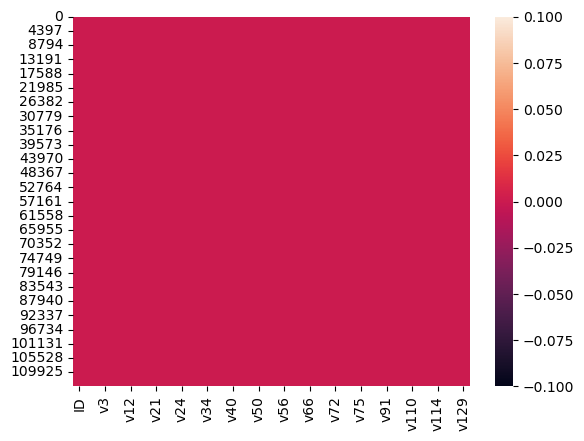

In [23]:
# imputation 결과 확인

sns.heatmap(train_clean.isnull(), cbar=True)

### 어떤 칼럼이 가장 target에 영향을 주는지 확인해보기

In [70]:
# 숫자형 데이터를 가지고 있는 칼럼들 
num_corr = train_clean[num_cols].corr()
# sns.heatmap(num_corr, annot=True)
num_corr['target'].sort_values()

# 가장 영향을 많이 미치는 수치형 데이터 칼럼은 50

v62      -0.093709
v119     -0.047535
v123     -0.045113
v48      -0.042766
v85      -0.040087
            ...   
v14       0.130668
v129      0.142141
v10       0.148492
v50       0.241545
target    1.000000
Name: target, Length: 114, dtype: float64

In [71]:
# 범주형(카테고리) 데이터 상관관계 확인
# phi corrlation을 사용해보자

from scipy.stats import chi2_contingency, chisquare

def phi_correlation(cat_column, target_column):
    # contingency table 생성
    contingency_table = pd.crosstab(cat_column, target_column)

    # Chi-squared 테스트 진행
    chi2, _, _, _ = chi2_contingency(contingency_table)

    # Phi 상관관계 계산
    n = contingency_table.sum().sum()
    phi_corr = np.sqrt(chi2 / n)

    return phi_corr


phi_corr = {}
for col in cat_cols:
    phi_value = phi_correlation(train_clean[col], train_clean['target'])
    print(f'{col}과 target간의 Phi 상관관계: {phi_value}')
    phi_corr[col] = phi_value # 결과 저장


v3과 target간의 Phi 상관관계: 0.02790962104322291
v22과 target간의 Phi 상관관계: 0.4250114043723493
v24과 target간의 Phi 상관관계: 0.04534039190791063
v31과 target간의 Phi 상관관계: 0.1790304414270061
v47과 target간의 Phi 상관관계: 0.1703312498545568
v52과 target간의 Phi 상관관계: 0.016084765262482443
v56과 target간의 Phi 상관관계: 0.23931450300740376
v66과 target간의 Phi 상관관계: 0.1519577686336791
v71과 target간의 Phi 상관관계: 0.037394282464145806
v74과 target간의 Phi 상관관계: 0.02861173327729047
v75과 target간의 Phi 상관관계: 0.006415511589036579
v79과 target간의 Phi 상관관계: 0.20493833346106477
v91과 target간의 Phi 상관관계: 0.03205585109072762
v107과 target간의 Phi 상관관계: 0.03205585109072762
v110과 target간의 Phi 상관관계: 0.1650667554869871
v112과 target간의 Phi 상관관계: 0.02598122142938925
v125과 target간의 Phi 상관관계: 0.041221243977528556


In [72]:
dict(sorted(phi_corr.items(), key=lambda item: item[1]))

# 가장 많이 영향을 끼치는 범주형 데이터 칼럼은 22와 56

{'v75': 0.006415511589036579,
 'v52': 0.016084765262482443,
 'v112': 0.02598122142938925,
 'v3': 0.02790962104322291,
 'v74': 0.02861173327729047,
 'v91': 0.03205585109072762,
 'v107': 0.03205585109072762,
 'v71': 0.037394282464145806,
 'v125': 0.041221243977528556,
 'v24': 0.04534039190791063,
 'v66': 0.1519577686336791,
 'v110': 0.1650667554869871,
 'v47': 0.1703312498545568,
 'v31': 0.1790304414270061,
 'v79': 0.20493833346106477,
 'v56': 0.23931450300740376,
 'v22': 0.4250114043723493}

### v50, v26, v22를 각각 타겟 변수와 비교

In [73]:
high_corr_cols = ['v22', 'v50', 'v56']

# train_clean[high_corr_cols] ## v50 = numeric

# sns.barplot(x='v22', hue='target', kind='count', data=train_clean, height=6, aspect=1.5)
# plt.title(f'{col}칼럼 변수와 타겟의 연관성')
# plt.show()
# train_clean[high_corr_cols].plot(x='target', kind='bar')

# plt.title('xxx')
# plt.ylabel('count')
# plt.show()

# 데이터 모델링

## 데이터 모델링 준비
- 데이터 인코딩
- test and train split

In [16]:
X = train_clean.drop(columns=['target','ID'], axis=1)
y = train_clean['target']

In [45]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

# 범주형 데이터 인코딩
cat_list = X.select_dtypes(include=['object', 'category']).columns.tolist()

for col in cat_list:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.fit_transform(X_test[col])

In [46]:
# encoding 결과 확인
X_train.head()

,v50,v66,v110,v56,v24,v47,v31,v12,v34,v10
58951,1.627174,0,1,15,3,2,0,6.402349,5.850610,1.291028
40239,0.820189,0,1,15,4,2,0,7.078407,4.645568,1.816193
24463,0.369746,0,1,15,4,2,0,6.469146,4.929282,0.765864
24620,1.295577,0,0,76,3,6,0,6.730578,5.556241,1.575493
43741,2.619029,1,1,46,2,2,0,6.816791,5.971398,2.341356


### 모델 학습 및 평가

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

lr = LogisticRegression(solver='liblinear', max_iter=2000)

# 모델 학습
lr.fit(X_train, y_train)

# 예측 모델
y_pred_tr_proba = lr.predict_proba(X_train)
y_pred_test_proba = lr.predict_proba(X_test)

# 손실함수 계산
print(f'현재 Train Log Loss: {log_loss(y_train, y_pred_tr_proba)}')
print(f'현재 Test Log Loss: {log_loss(y_test, y_pred_test_proba)}')



현재 Train Log Loss: 0.5005372608093421
현재 Test Log Loss: 0.4925824585927697


Log Loss는 분류 모델의 확률을 예측하는 퍼포먼스를 평가 지표입니다.   
해당 메트릭은 얼만큼 예측한 확률들이 실제 클래스 라벨과 맞아 떨어지는지 측정합니다.   
낮은 값의 log loss는 더 좋은 성능을 내고 있음을 나타냅니다. 즉, 0에 가까울수록 높은 완성도를 의미합니다.   
현재 모델의 Log loss 값은 0.50이며, 나쁜 지표는 아니지만 개선이 필요함을 나타냅니다.

In [48]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# 클래스 라벨 예측
y_pred_tr = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

# 분류 레포트
classification_rep = classification_report(y_test, y_pred_test)

# 결과
print('Test Accuracy: ', accuracy_score(y_test, y_pred_test))
print('Test ROC AUC: ', roc_auc_score(y_test, y_pred_test))
print(classification_rep)

Test Accuracy:  0.7728081173280462
Test ROC AUC:  0.5455420193466357
              precision    recall  f1-score   support

           0       0.57      0.12      0.20      8017
           1       0.78      0.97      0.87     26280

    accuracy                           0.77     34297
   macro avg       0.68      0.55      0.53     34297
weighted avg       0.73      0.77      0.71     34297



Tuning 전 모델 성능 해석: (threshold=40)
--------
Test Accuracy:  0.7724290754293378   
Test ROC AUC:  0.5382733447512316   
              precision    recall  f1-score   support

           0       0.58      0.10      0.17      8017
           1       0.78      0.98      0.87     26280

    accuracy                           0.77     34297
    macro avg       0.68      0.54      0.52     34297
    weighted avg       0.73      0.77      0.70     34297
   
    

threshold=45
-----
Test Accuracy:  0.7715835204245269
Test ROC AUC:  0.543052610425069
              precision    recall  f1-score   support

           0       0.56      0.11      0.19      8017
           1       0.78      0.97      0.87     26280

    accuracy                           0.77     34297
    macro avg       0.67      0.54      0.53     34297
    weighted avg       0.73      0.77      0.71     34297


### Scaler & Pipeline

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


estimators = [
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(solver='liblinear', max_iter=6000))
]

# pipe 정리
pipe = Pipeline(estimators)

In [50]:
# pipe사용 시 내가 지정한 스케일러와 logistic regression을 한번에 수행!
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LogisticRegression(max_iter=6000, solver='liblinear'))])

In [51]:
# pipeline test
y_pred_tr = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

print('Test Acc: ', accuracy_score(y_train, y_pred_tr))
print('Test ROC AUC: ', roc_auc_score(y_test, y_pred_test))


Test Acc:  0.7646206138158552
Test ROC AUC:  0.5454796518775076


- 오히려 standard scaler 적용 후 근소하게 낮아지는 현상 발생

## 하이퍼 파라미터 튜닝

In [52]:
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(max_iter=6000)

# 하이퍼 파라미터 설정
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2', 'none'],
    'solver': ['lbfgs', 'liblinear']
}

In [53]:
# 교차 검증
grid_search = GridSearchCV(estimator=lr, 
                           param_grid=param_grid, 
                           scoring='neg_log_loss', 
                           cv=5, verbose=1, n_jobs=-1
                           )


# 모델 학습
grid_search.fit(X_train, y_train)

# 최적의 파라미터 
best_params = grid_search.best_params_
print(f'최적의 파라미터: {best_params}')

# 최고 성능 모델
best_log_loss = grid_search.best_score_
print(f'최적의 log loss: {best_log_loss}')


Fitting 5 folds for each of 24 candidates, totalling 120 fits
최적의 파라미터: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
최적의 log loss: -0.5007193462145457


t = 40:   
최적의 파라미터: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}   
최적의 log loss: -0.4968598900942268

    
    
t = 45:
최적의 파라미터: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}   
최적의 log loss: -0.4964018185258318   
=> C값이 달라졌다.

In [54]:
accuracy = accuracy_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_test_proba[:, 1])
classification_rep = classification_report(y_test, y_pred_test)

print(f"정확도: {accuracy}")
print(f"ROC AUC: {roc_auc}")

print(classification_rep) # 예측 평가

정확도: 0.7727789602589148
ROC AUC: 0.7130751500473973
              precision    recall  f1-score   support

           0       0.57      0.12      0.20      8017
           1       0.78      0.97      0.87     26280

    accuracy                           0.77     34297
   macro avg       0.68      0.55      0.53     34297
weighted avg       0.73      0.77      0.71     34297



when t = 40:   
---- 
정확도: 0.7698632533457737   
ROC AUC: 0.7186120096013626   
              precision    recall  f1-score   support

           0       0.59      0.05      0.09      8017
           1       0.77      0.99      0.87     26280

    accuracy                           0.77     34297
    macro avg       0.68      0.52      0.48     34297
    weighted avg       0.73      0.77      0.69     34297


# 최적의 파라미터를 적용한 모델을 test 데이터에 적용

In [55]:
# 그리드 서치에서 찾아낸 최적의 파라미터로 모델 재학습
lr_clf_best = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', max_iter=6000, random_state=13)
lr_clf_best.fit(X_train, y_train)
y_pred_test_proba = lr_clf_best.predict_proba(X_test)


In [56]:
y_pred_test = lr_clf_best.predict(X_test)

print(f'튜닝 후 Test Log Loss: {log_loss(y_test, y_pred_test_proba)}')
print()
print(classification_report(y_test, y_pred_test))

튜닝 후 Test Log Loss: 0.4925939988763611

              precision    recall  f1-score   support

           0       0.57      0.12      0.20      8017
           1       0.78      0.97      0.87     26280

    accuracy                           0.77     34297
   macro avg       0.67      0.55      0.53     34297
weighted avg       0.73      0.77      0.71     34297



When t = 40: 
----
              precision    recall  f1-score   support

           0       0.58      0.08      0.14      8017
           1       0.78      0.98      0.87     26280

    accuracy                           0.77     34297
    macro avg       0.68      0.53      0.50     34297
    weighted avg       0.73      0.77      0.70     34297
   
    
Log-loss: 튜닝전 0.4892898477454462과 튜닝 후 0.48747215256506593. 큰차이 없음


    

when t = 45 & C = 0.1:
----
튜닝 후 Test Log Loss: 0.48654743561762326

              precision    recall  f1-score   support

           0       0.58      0.07      0.13      8017
           1       0.78      0.98      0.87     26280

    accuracy                           0.77     34297
    macro avg       0.68      0.53      0.50     34297
    weighted avg       0.73      0.77      0.70     34297

여러 파라미터 (C, penalty level, 결측치 threshold 등)을 조정해도 비슷한 성능을 발휘합니다. 그래서 decision tree, random forest, lightgbm 알고리즘을 적용하여 성능을 비교분석할 예정입니다.   
또한, 결측치 threshold를 조정하여도 결과에 큰 차이가 없기에 45로 상향조정하고 프로젝트를 진행하기로 하였습니다.

## 중요 변수 파악
- SHAP value를 통해 각 피쳐와 타겟 변수간 영향 측정

In [87]:
# !pip install shap

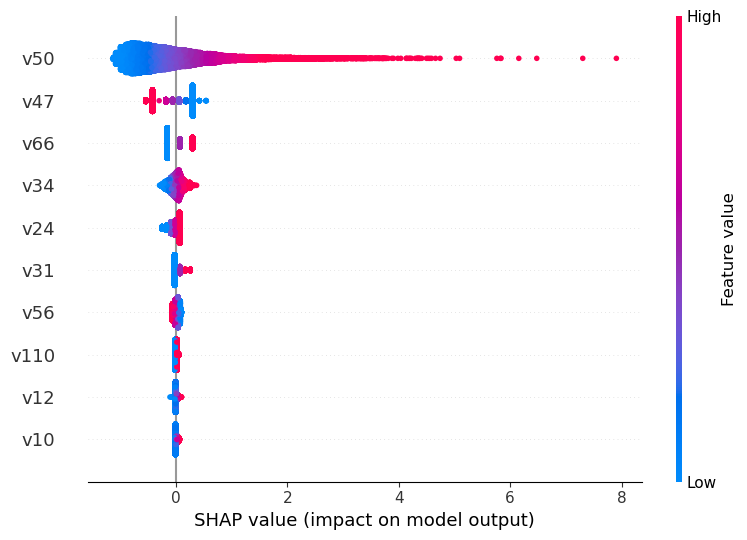

In [57]:
import shap
shap.initjs() # initialize

explainer = shap.LinearExplainer(lr_clf_best, X_train)

shap_values = explainer.shap_values(X_test)

# 섀플리 시각화
shap.summary_plot(shap_values, X_test)


# Decision Tree와 Random Forest 알고리즘을 사용한 모델링

In [92]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# 훈련 & 테스트 데이터 초기화
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

# 범주형 데이터 인코딩
cat_list = X.select_dtypes(include=['object', 'category']).columns.tolist()

for col in cat_list:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.fit_transform(X_test[col])

dt_clf = DecisionTreeClassifier(random_state=13, max_depth=4)
dt_clf.fit(X_train, y_train)

y_pred_dt = dt_clf.predict(X_test)
y_pred_proba_dt = dt_clf.predict_proba(X_test)[:,1]

accuracy_dt = accuracy_score(y_test, y_pred_dt)
roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt)

print('Decision Tree 퍼포먼스')
print(f'accuracy: {accuracy_dt}')
print(f'roc_auc: {roc_auc_dt}')
print(f'report: {classification_report(y_test, y_pred_dt)}')

Decision Tree 퍼포먼스
accuracy: 0.7794267720208765
roc_auc: 0.7217970649888015
report:               precision    recall  f1-score   support

           0       0.62      0.14      0.23      8017
           1       0.79      0.97      0.87     26280

    accuracy                           0.78     34297
   macro avg       0.71      0.56      0.55     34297
weighted avg       0.75      0.78      0.72     34297



## Decision Tree 최적의 HyperParameter 찾기

In [94]:
dt_clf = DecisionTreeClassifier(random_state=13)


param_grid = {
    'max_depth': [None, 4, 8, 12],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

# 교차 검증
grid_search = GridSearchCV(estimator=dt_clf, param_grid=param_grid, scoring='neg_log_loss', cv=5, n_jobs=-1)

# 모델 학습
grid_search.fit(X_train, y_train)

# 최적의 파라미터
best_params = grid_search.best_params_
print('best params: ', best_params)

# 최고 성능 점수
best_log_loss = grid_search.best_score_
print('best score: ', best_log_loss)


best params:  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}
best score:  -0.5245968659586694


### 하이퍼 파라미터 튜닝 후 DT 재학습

In [95]:
dt_clf_best = DecisionTreeClassifier(criterion='gini', max_depth=4, max_features='sqrt', min_samples_leaf=1, min_samples_split=10)
dt_clf_best.fit(X_train, y_train)

y_pred_test_best = dt_clf_best.predict(X_test)
y_pred_test_proba_best = dt_clf_best.predict_proba(X_test)

# tuning 후 성능
print(f'튜닝 후 Test Log Loss: {log_loss(y_test, y_pred_test_proba)}')
print()
print(classification_report(y_test, y_pred_test))


튜닝 후 Test Log Loss: 0.48654743561762326

              precision    recall  f1-score   support

           0       0.58      0.07      0.13      8017
           1       0.78      0.98      0.87     26280

    accuracy                           0.77     34297
   macro avg       0.68      0.53      0.50     34297
weighted avg       0.73      0.77      0.70     34297



## Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=13)

# 훈련 & 테스트 데이터 초기화
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

# 범주형 데이터 인코딩
cat_list = X.select_dtypes(include=['object', 'category']).columns.tolist()

for col in cat_list:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.fit_transform(X_test[col])

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]

accuracy_rf = accuracy_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print('Random Forest 퍼포먼스')
print(f'accuracy: {accuracy_rf}')
print(f'roc_auc: {roc_auc_rf}')
print(f'log loss: {log_loss(y_test, y_pred_proba_rf)}')
print(f'report: {classification_report(y_test, y_pred_rf)}')



Random Forest 퍼포먼스
accuracy: 0.7832463480770913
roc_auc: 0.7403530435419863
log loss: 0.4754543724507544
report:               precision    recall  f1-score   support

           0       0.61      0.21      0.31      8017
           1       0.80      0.96      0.87     26280

    accuracy                           0.78     34297
   macro avg       0.70      0.58      0.59     34297
weighted avg       0.75      0.78      0.74     34297



## RF Feature Engineering: SHAP Imp 

In [22]:
import shap

# Initialize TreeExplainer with the best Random Forest model
explainer = shap.TreeExplainer(rf)

# Calculate SHAP values for the test data
# Note: You can use a sample of X_test if computation is slow
shap_values = explainer.shap_values(X_test)

# Visualize the summary plot for the most influential features
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values[1], X_test)  # Use shap_values[1] if it's binary classification
plt.title('SHAP Summary Plot for Random Forest')
plt.show()

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 1000x800 with 0 Axes>

## Random Forest 최적의 파라미터 찾기

In [100]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 300], # 결정나무의 개수
    'max_depth': [5, 10, 15, None], # 각 트리의 깊이 조절
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'max_leaf_nodes': [None, 50, 100]
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=13),
    param_distributions=param_dist,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=13,
    n_jobs=-1
)
# 모델 학습
random_search.fit(X_train, y_train)


# 최적의 파라미터와 성능 확인
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)


best params:  {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
best score:  -0.48081891164532314


### RF 하이퍼파라미터 튜닝 후 재학습

In [101]:
rf_best = RandomForestClassifier(max_depth=20, min_samples_split=2, n_estimators=200)
rf_best.fit(X_train, y_train)

y_pred_test_best_rf = rf_best.predict(X_test)
y_pred_test_proba_best_rf = rf_best.predict_proba(X_test)

# tuning 후 성능
print(f'튜닝 후 Test Log Loss: {log_loss(y_test, y_pred_test_proba_best_rf)}')
print()
print(classification_report(y_test, y_pred_test_best_rf))


튜닝 후 Test Log Loss: 0.4725984615125052

              precision    recall  f1-score   support

           0       0.67      0.15      0.24      8017
           1       0.79      0.98      0.87     26280

    accuracy                           0.78     34297
   macro avg       0.73      0.56      0.56     34297
weighted avg       0.76      0.78      0.73     34297



하이퍼 파라미터 튜닝 후에도 주요 지표들 (logloss, f1 score, recall, precision 등)이 튜닝 전과 큰차이가 없습니다. 

# LightGBM 

In [1]:
conda install lightbgm

Channels:
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - lightbgm

Current channels:

  - defaults
  - https://conda.anaconda.org/conda-forge/noarch
  - https://conda.anaconda.org/conda-forge/osx-arm64

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.



Note: you may need to restart the kernel to use updated packages.


In [7]:
import lightgbm as lgb

# 훈련 & 테스트 데이터 초기화
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

# 범주형 데이터 인코딩
cat_list = X.select_dtypes(include=['object', 'category']).columns.tolist()

for col in cat_list:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.fit_transform(X_test[col].astype(str))

# 학습
lgbm_model = lgb.LGBMClassifier(n_estimators=100, random_state=13)
lgbm_model.fit(X_train, y_train)

# 예측 및 평가
y_pred_lgbm = lgbm_model.predict(X_test)
y_pred_lgbm_proba = lgbm_model.predict_proba(X_test)[:, 1]


TypeError: descriptor '__call__' for 'type' objects doesn't apply to a 'property' object

# EBM

In [24]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, classification_report

# 데이터 분리 (Train/Test)
X = train_clean.drop(columns=['target', 'ID'], axis=1)
y = train_clean['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

# EBM 모델 초기화 및 학습
ebm = ExplainableBoostingClassifier(random_state=13)
ebm.fit(X_train, y_train)

# 예측 수행
y_pred = ebm.predict(X_test)
y_pred_proba = ebm.predict_proba(X_test)[:, 1]

# 모델 성능 평가
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
logloss = log_loss(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(classification_report(y_test, y_pred))

# 변수 중요도와 개별 변수의 영향력 시각화
ebm_global = ebm.explain_global()
show(ebm_global)

Accuracy: 0.7844
ROC AUC: 0.7508
Log Loss: 0.4648
              precision    recall  f1-score   support

           0       0.63      0.18      0.29      8017
           1       0.80      0.97      0.87     26280

    accuracy                           0.78     34297
   macro avg       0.71      0.58      0.58     34297
weighted avg       0.76      0.78      0.74     34297



<!-- http://127.0.0.1:7001/13143488976/ -->

# Feature Engineering

In [28]:
# Top 10 features와 그 중요도 추출
feature_data = ebm_global.data()
feature_names = feature_data['names']
feature_scores = feature_data['scores']

features_with_scores = sorted(zip(feature_names, feature_scores), key=lambda x: x[1], reverse=True)
top_features = [name for name, score in features_with_scores[:10]]
top_scores = [score for name, score in features_with_scores[:10]]

In [33]:
fe1 = train_clean[['target', 'ID', 'v50', 'v66', 'v110', 'v56', 'v24', 'v47', 'v31', 'v12', 'v34', 'v10']]

In [34]:
# 데이터 분리 (Train/Test)
X = fe1.drop(columns=['target', 'ID'], axis=1)
y = fe1['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

# EBM 모델 초기화 및 학습
ebm = ExplainableBoostingClassifier(random_state=13)
ebm.fit(X_train, y_train)

# 예측 수행
y_pred = ebm.predict(X_test)
y_pred_proba = ebm.predict_proba(X_test)[:, 1]

# 모델 성능 평가
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
logloss = log_loss(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(classification_report(y_test, y_pred))

# 변수 중요도와 개별 변수의 영향력 시각화
ebm_global = ebm.explain_global()
show(ebm_global)

Accuracy: 0.7833
ROC AUC: 0.7468
Log Loss: 0.4671
              precision    recall  f1-score   support

           0       0.63      0.17      0.27      8017
           1       0.79      0.97      0.87     26280

    accuracy                           0.78     34297
   macro avg       0.71      0.57      0.57     34297
weighted avg       0.76      0.78      0.73     34297



<!-- http://127.0.0.1:7001/13162981200/ -->

# Hype Parameter

In [40]:
from sklearn.model_selection import RandomizedSearchCV

# Define the adjusted parameter grid
param_dist = {
    'max_bins': [128, 256, 512],            
    'max_interaction_bins': [16, 32, 64],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_rounds': [100, 200, 500],     
    'min_samples_leaf': [1, 2, 5, 10],
    'max_leaves': [3, 5, 10, 15]
}

# Initialize the EBM model
ebm = ExplainableBoostingClassifier(random_state=13)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=ebm,
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter settings sampled
    scoring='neg_log_loss',  # Change based on your metric
    cv=3,
    n_jobs=-1,
    random_state=13,
    verbose=1
)

# Perform the search
random_search.fit(X_train, y_train)

# Print best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best ROC AUC Score:", random_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'min_samples_leaf': 2, 'max_rounds': 500, 'max_leaves': 3, 'max_interaction_bins': 64, 'max_bins': 512, 'learning_rate': 0.05}
Best ROC AUC Score: -0.4749316358417223


## hype param 튜닝 후 재학습

In [41]:
ebm_best = ExplainableBoostingClassifier(
    min_samples_leaf=2, 
    max_rounds=500, 
    max_leaves=3, 
    max_interaction_bins=64, 
    max_bins=512, 
    learning_rate=0.05
)
ebm_best.fit(X_train, y_train)

y_pred_test_best = ebm_best.predict(X_test)
y_pred_test_proba_best = ebm_best.predict_proba(X_test)

# tuning 후 성능
print(f'튜닝 후 Test Log Loss: {log_loss(y_test, y_pred_test_proba_best)}')
print(f'rocauc after tuning: {roc_auc_score(y_test, y_pred_test_best)}')
print()
print(classification_report(y_test, y_pred_test_best))

튜닝 후 Test Log Loss: 0.46693387588063023
rocauc after tuning: 0.5717893426240928

              precision    recall  f1-score   support

           0       0.63      0.17      0.27      8017
           1       0.79      0.97      0.87     26280

    accuracy                           0.78     34297
   macro avg       0.71      0.57      0.57     34297
weighted avg       0.76      0.78      0.73     34297

